In [4]:
# imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import pickle
from tqdm.notebook import tqdm
from fastai.text import *
from fastai.text.all import *
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [5]:
# install kaggle
!pip install -q kaggle

In [6]:
# upload json file with authorised credentials 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"cristianlucianpop","key":"88d7f5c37155b6a54edba0b80878757f"}'}

In [7]:
# create folder kaggle
!mkdir -p ~/.kaggle

In [8]:
# move json file to kaggle folder
!cp kaggle.json ~/.kaggle/

In [9]:
# check what files are in the kaggle folder
!ls ~/.kaggle

kaggle.json


In [10]:
# hide credentials
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
# search for flickr datasets available on Kaggle
!kaggle datasets list -s "flickr"

ref                                            title                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------  ------------------------------  -----  -------------------  -------------  ---------  ---------------  
hsankesara/flickr-image-dataset                Flickr Image dataset              8GB  2018-06-12 20:34:20          30411        429  0.7058824        
adityajn105/flickr8k                           Flickr 8k Dataset                 1GB  2020-04-27 07:27:19          37608        240  0.75             
arnaud58/flickrfaceshq-dataset-ffhq            Flickr-Faces-HQ Dataset (FFHQ)   19GB  2020-03-09 12:24:45           9148         91  0.9375           
arnaud58/landscape-pictures                    Landscape Pictures              620MB  2020-06-05 19:19:55          11580        184  0.875            
shadabhussain/flickr8k                         Flickr8K                          2GB  2019-03-

In [12]:
# download flickr8k dataset
!kaggle datasets download -d adityajn105/flickr8k

flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
# check what files are in the current folder
!ls

 dataset       'kaggle (1).json'   kaggle.json	 output
 flickr8k.zip  'kaggle (2).json'   model.png	 sample_data


In [20]:
# unzip the dataset
import zipfile

zip_ref = zipfile.ZipFile('flickr8k.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [21]:
# check what files are in the current folder
!ls

 captions.txt   Images		   kaggle.json
 flickr8k.zip  'kaggle (1).json'   sample_data


In [22]:
# create working folders and move dataset to the dataset folder
!mkdir dataset
!mkdir output

!mv Images dataset
!mv captions.txt dataset
!ls

 dataset   flickr8k.zip  'kaggle (1).json'   kaggle.json   output   sample_data


In [14]:
# paths for dataset and output
dataset_path = "/content/dataset"
output_path = "/content/output"

In [15]:
# show how many captions each image has
text_path = "/content/dataset/captions.txt"

columns = ["Image", "Caption"]
data_text = pd.read_csv(text_path, header = None, names = columns, skiprows = 1)

text_df = pd.DataFrame(data_text, columns = ["Image", "Caption"])
unique_names = np.unique(text_df.Image.values)

print("Total number of captions: {}".format(len(text_df)))
print("The number of unique names is: {}".format(len(unique_names)))
print("Captions are distributed as follows: ")
print(Counter(text_df.Image.values[:30]))

Total number of captions: 40455
The number of unique names is: 8091
Captions are distributed as follows: 
Counter({'1000268201_693b08cb0e.jpg': 5, '1001773457_577c3a7d70.jpg': 5, '1002674143_1b742ab4b8.jpg': 5, '1003163366_44323f5815.jpg': 5, '1007129816_e794419615.jpg': 5, '1007320043_627395c3d8.jpg': 5})


In [16]:
# show image shapes
from PIL import Image
from pathlib import Path 

image_path = "/content/dataset/Images"
search_path = Path(image_path)
image_number = len([*search_path.iterdir()])

image_sizes = []

for dirpath, _, filenames in os.walk(image_path):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, height = img.size
            image_sizes.append(
                {
                    'Name': path_image,
                    'Width': width,
                    'Height': height
                }
            )
    pd.DataFrame(image_sizes)
    
print ("Total number of images: ", image_number)
print("Image shapes:")    
print('\n'.join(map(str, image_sizes[:30])))

Total number of images:  8091
Image shapes:
{'Name': '525863257_053333e612.jpg', 'Width': 500, 'Height': 398}
{'Name': '3044536048_e615466e7f.jpg', 'Width': 500, 'Height': 276}
{'Name': '2966552760_e65b22cd26.jpg', 'Width': 500, 'Height': 333}
{'Name': '2240539658_dea8db6e55.jpg', 'Width': 500, 'Height': 375}
{'Name': '3504479370_ff2d89a043.jpg', 'Width': 500, 'Height': 375}
{'Name': '1445123245_c7b9db0e0c.jpg', 'Width': 500, 'Height': 375}
{'Name': '2923475135_a6b6e13d26.jpg', 'Width': 500, 'Height': 333}
{'Name': '2444821454_22a346c996.jpg', 'Width': 500, 'Height': 335}
{'Name': '3240090389_97a8c5d386.jpg', 'Width': 500, 'Height': 339}
{'Name': '2593406865_ab98490c1f.jpg', 'Width': 333, 'Height': 500}
{'Name': '3671933270_d124e9a1a4.jpg', 'Width': 500, 'Height': 335}
{'Name': '743571049_68080e8751.jpg', 'Width': 488, 'Height': 500}
{'Name': '422756764_e7eaac76bf.jpg', 'Width': 500, 'Height': 333}
{'Name': '2806710650_e201acd913.jpg', 'Width': 500, 'Height': 333}
{'Name': '2501595799_

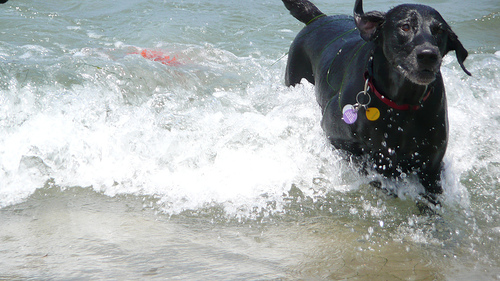

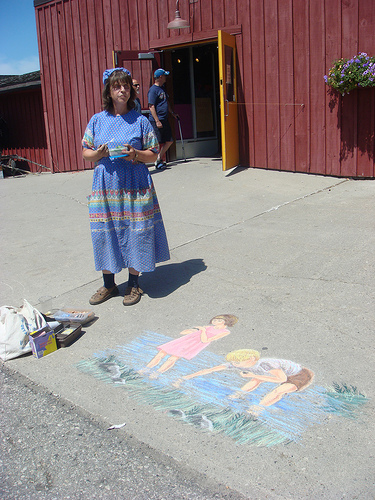

In [17]:
# display images to check quality
from PIL import Image

img = Image.open(r"/content/dataset/Images/1022975728_75515238d8.jpg")
img.show()

img = Image.open(r"/content/dataset/Images/1093737381_b313cd49ff.jpg")
img.show()

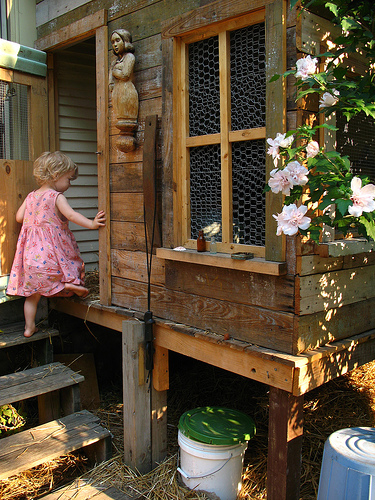

""
1
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [18]:
# display first image with all captions assigned
from PIL import Image

img = Image.open(r"/content/dataset/Images/1000268201_693b08cb0e.jpg")
img.show()

captions = pd.read_csv('/content/dataset/captions.txt', header=None, names=None, index_col=0 ,usecols=[1], skiprows=1)
captions.head(5)

In [19]:
# content of the text file
captions = pd.read_csv("/content/dataset/captions.txt")
captions.head(20)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


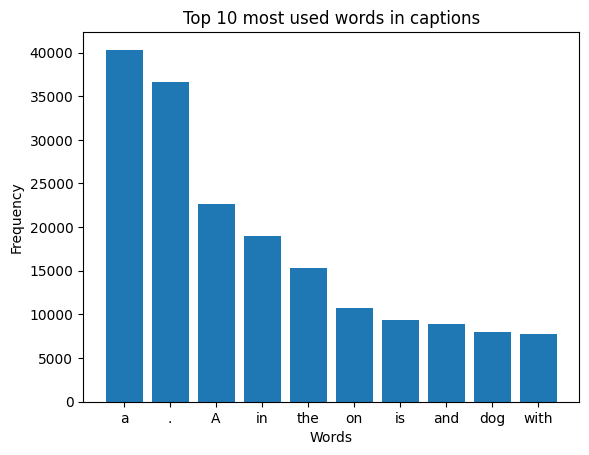

In [20]:
# plot top 10 most used words

df = pd.DataFrame(captions)
description_list = df['caption'].values.tolist()
# count the most used words
word_frequency = Counter(" ".join(description_list).split()).most_common(10)

words = [word for word, _ in word_frequency]
counts = [counts for _, counts in word_frequency]

plt.bar(words, counts)
plt.title("Top 10 most used words in captions")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()

In [21]:
# load VGG16 model but remove the last layer as there isn't needed for this task 
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
# extract features
features = {}
directory = os.path.join(dataset_path, "Images")

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

pickle.dump(features, open(os.path.join(output_path, 'features.pkl'), 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

In [23]:
# load image features
with open(os.path.join(output_path, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [24]:
# load image captions
with open(os.path.join(dataset_path, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [49]:
# create mapping of image to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

# dictionary size
print("Dictionary size: ", len(mapping))

  0%|          | 0/40456 [00:00<?, ?it/s]

Dictionary size:  8091


In [50]:
# function to clean the dictionary
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special characters, punctuation 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to each caption
            caption = 'start ' + " ".join([word for word in caption.split() if len(word)>1]) + ' stop'
            captions[i] = caption

print("Captions before cleaning:")
mapping["1000268201_693b08cb0e"]

Captions before cleaning:


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [51]:
# clean the dictionary
clean(mapping)

print("Captions after cleaning:")
mapping["1000268201_693b08cb0e"]

Captions after cleaning:


['start child in pink dress is climbing up set of stairs in an entry way stop',
 'start girl going into wooden building stop',
 'start little girl climbing into wooden playhouse stop',
 'start little girl climbing the stairs to her playhouse stop',
 'start little girl in pink dress going into wooden cabin stop']

In [53]:
# display the number of captions in the file
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

print("Total number of captions: ", len(all_captions))

Total number of captions:  40455


In [54]:
# tokenize the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocabulary_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(all_captions)
image_sequence = sequences[0]
sentence = tokenizer.sequences_to_texts([image_sequence])
tokens = tokenizer.sequences_to_texts([image_sequence])[0].split()
token_number = len(image_sequence)

print("Sentence for first image:", sentence)
print("Tokens for first image:", tokens)
print("Number of tokens for first image:", token_number)
print("The size of the vocabulary is: ", vocabulary_size)

Sentence for first image: ['start child in pink dress is climbing up set of stairs in an entry way stop']
Tokens for first image: ['start', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'stop']
Number of tokens for first image: 16
The size of the vocabulary is:  8483


In [55]:
# display 10 most used words
words_number = 10
word_counts = tokenizer.word_counts

print(f"\nTop 10 most used words after cleaning:")
for word, count in sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:words_number]:
    print(f"{word}: {count}")


Top 10 most used words after cleaning:
stop: 40491
start: 40464
in: 18986
the: 18419
on: 10745
is: 9345
and: 8862
dog: 8138
with: 7765
man: 7274


In [56]:
# maximum length of captions
max_length = max(len(caption.split()) for caption in all_captions)
print("The longest caption has", max_length, "tokens")

The longest caption has 35 tokens


In [32]:
# split the image set into training and testing
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]
print("Images for training: ", int(len(train)))
print("Images for testing: ", int(len(test)))

Images for training:  7281
Images for testing:  810


In [71]:
# function to create sequence pairs
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocabulary_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocabulary_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

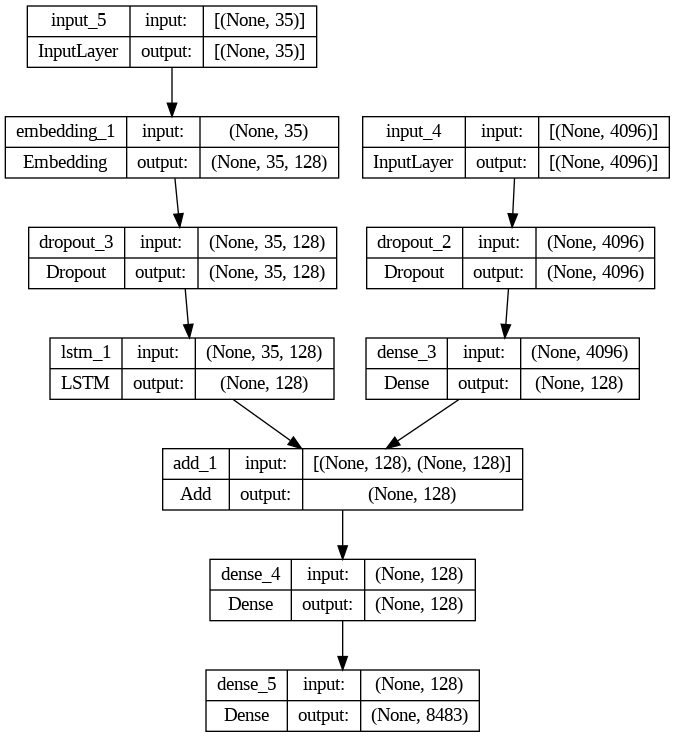

In [58]:
# encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(128, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocabulary_size, 128, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(128)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(128, activation='relu')(decoder1)
outputs = Dense(vocabulary_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [83]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size # 227

for epoch in range(epochs):
    # create generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocabulary_size, batch_size)
    # fit the model
    print("Epoch number:", epoch + 1)
    model.fit_generator(generator, steps_per_epoch = steps, verbose = 1)

Epoch number: 1


<ipython-input-83-870bac126e03>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, steps_per_epoch = steps, verbose = 1)


227/227 [==============================] - 39s 172ms/step - loss: 2.7692
Epoch number: 2
227/227 [==============================] - 39s 173ms/step - loss: 2.7399
Epoch number: 3
227/227 [==============================] - 41s 180ms/step - loss: 2.7125
Epoch number: 4
227/227 [==============================] - 38s 168ms/step - loss: 2.6900
Epoch number: 5
227/227 [==============================] - 39s 171ms/step - loss: 2.6674
Epoch number: 6
227/227 [==============================] - 39s 171ms/step - loss: 2.6454
Epoch number: 7
227/227 [==============================] - 37s 164ms/step - loss: 2.6273
Epoch number: 8
227/227 [==============================] - 38s 169ms/step - loss: 2.6079
Epoch number: 9
227/227 [==============================] - 38s 167ms/step - loss: 2.5922
Epoch number: 10
227/227 [==============================] - 38s 169ms/step - loss: 2.5766
Epoch number: 11
227/227 [==============================] - 40s 174ms/step - loss: 2.5624
Epoch number: 12
227/227 [=========

In [84]:
# function to return the corresponding words 
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [85]:
# predict caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'stop':
            break
      
    return in_text

In [86]:
# function to display image with caption
import random

def generate_caption():
    image_id = random.choice(test)
    
    img_path = os.path.join(dataset_path, "Images", image_id + ".jpg")
    image = Image.open(img_path)
    captions = mapping[image_id]
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    plt.imshow(image)
    plt.show()
    print(y_pred)

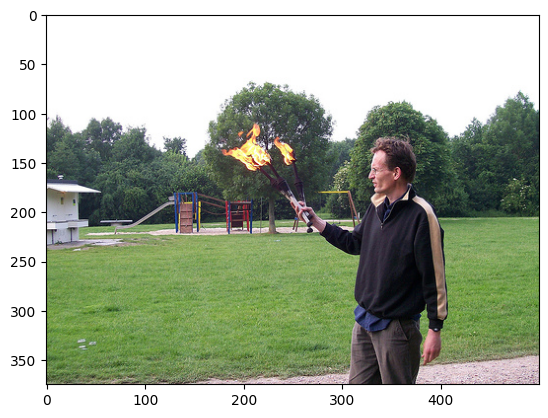

start man in black and white shirt and black pants and black pants and black pants are standing on grass stop


In [87]:
generate_caption()

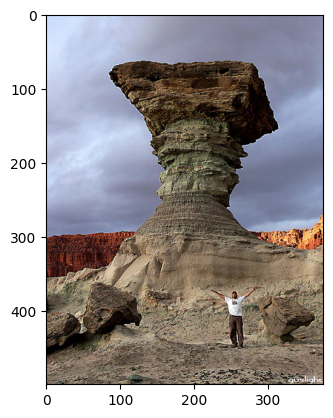

start man in black shirt is hiking on rock stop


In [88]:
# test the model
generate_caption()

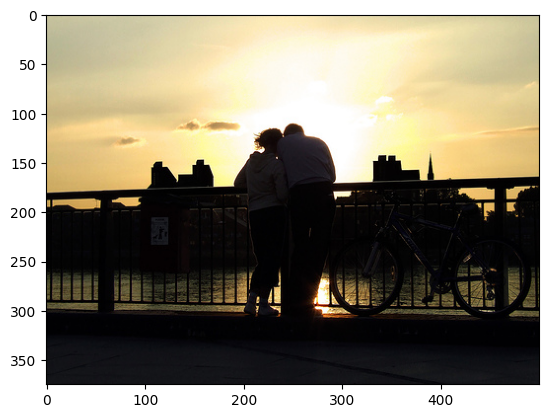

start two people are walking down the beach stop


In [92]:
generate_caption()

In [93]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

# function to calculate BLEU score
for key in tqdm(test):
    # get caption
    captions = mapping[key]
    # predict caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print("BLEU score: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU score: 0.319774
